# Analysis of the fluorescence recovery on parasite coats

The script gets its input from a config yml configuration file:
```yaml
filelist: /path/to/filelist.csv
summary: /path/to/results.csv
```
with filelist a csv file with columns 

|Filename| Start time [min]| First frame|
|--------|-----------------|------------|

where Filename column pointing to a TIF image file with a matching -profile.csv file with the columns 

|Frame|Time [min]|Mean Intensity|
|-----|----------|--------------|

Finally, summary is the path to a csv file with the result of the analysis by the imagej macro.

## Load dataset
Open the config.yaml file and load the intensity profile for each file listed in the filelist.

In [1]:
from pathlib import Path
import yaml
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from functools import partial
from scipy.optimize import curve_fit
from scipy.special import erf, erfinv
from scipy.signal import medfilt

def madstd(x):
    """Maximum abosolute deviation of the standard deviation"""
    return 1.4826 * np.median(np.abs(x-np.median(x)))

def f1(s):             
    return madstd(s.to_frame())
f1.__name__ = 'madstd'
q25 = partial(pd.Series.quantile, q=0.25)
q25.__name__ ='25%'
q50 = partial(pd.Series.quantile, q=0.50)
q50.__name__ ='50%'
q75 = partial(pd.Series.quantile, q=0.75)
q75.__name__ ='75%'
def f2(s):             
    return pd.Series.quantile(s,0.75) -  pd.Series.quantile(s,0.25)
f2.__name__ ='25%-75%'



Load the summary.csv table

In [2]:
# Load the configuration file
with open('config.yml', 'r') as file:
    config = yaml.safe_load(file)

folder = Path(config['summary']).parent

# Load the summary file
summary = pd.read_csv(config['summary'])

# Decode the parasite index 
summary['Parasite'] = summary['Image'].transform(lambda x: int(x.split('_')[0].replace('Parasite','')))

# Order the files
summary.sort_values(by='Parasite', inplace=True, ignore_index=True)

# Drop previous estimate of model parameters
summary.drop(columns=['Time mid point [min]','Time constant [min]', '5%-95% recovery time [min]', 'Intensity amplitude [au]','Intensity offset [au]','Photo-bleaching [min]','R squared'], inplace=True)

summary.head()

,Image,Start time [min],First frame,Image width,Image height,Image slices,Image frames,Image pixel size,Image spacing,Image frame interval,Objective,Camera,Numerical Aperture,Parasite
0,Parasite1_from video on manuscript_211013_GFPR...,60,1,142,142,17,21,0.065091,0.4,29.971338,SR Apo TIRF AC 100xH,Hamamatsu Dual C11440-22C,1.49,1
1,Parasite2_from video on manuscript_211013_GFPR...,60,11,172,150,17,26,0.065091,0.4,29.971338,SR Apo TIRF AC 100xH,Hamamatsu Dual C11440-22C,1.49,2
2,Parasite3_211013_GFPRNF_RHtomato_30min_2min001...,30,1,155,148,13,10,0.065091,0.4,127.162109,SR Apo TIRF AC 100xH,Hamamatsu Dual C11440-22C,1.49,3
3,Parasite4_211013_GFPRNF_RHtomato_30min_2min001...,30,4,126,138,13,7,0.065091,0.4,127.162109,SR Apo TIRF AC 100xH,Hamamatsu Dual C11440-22C,1.49,4
4,Parasite5_231129_23MIN_1min.nd2 - 231129_23MIN...,23,1,42,55,9,16,0.233051,0.7,60.705688,Plan Fluor 40x Oil DIC H N2,Prime 95B A21B203017,1.30,5


Combine all profiles in one dataframe

In [3]:

# Load the filelist in a dataframe
filelist = pd.read_csv(config['filelist'])

# Decode the parasite index
filelist['Parasite'] = filelist['Filename'].transform(lambda x: int(x.split('_')[0].replace('Parasite','')))

# Order the files
filelist.sort_values(by='Parasite', inplace=True, ignore_index=True)

# Define a loading function for the profile files
def load_profile(folder, row):
    path = folder / row['Filename'].replace('.tif','-profile.csv')
    df = pd.read_csv(path)
    df['Parasite'] = row['Parasite']
    # Drop previous estimate of model
    df.drop(columns=['Model'], inplace=True)
    return df
    
# Load the individual intensity profiles from *-profile.csv files saved by the ImageJ macro
profiles = pd.concat([load_profile(folder, row) for row in filelist.iloc], ignore_index=True)
profiles.head()

,Frame,Time [min],Mean intensity,Fraction,Parasite
0,1,60.499522,109.944005,0.026449,1
1,2,60.999045,110.122265,0.040593,1
2,3,61.498567,110.066081,0.040723,1
3,4,61.998089,110.600591,0.051829,1
4,5,62.497612,111.520249,0.100390,1


## Estimation of model parameters from recorded intensity profiles
Re-estimate the parameters from the mean intensity profiles.

In [4]:
figure_folder = folder / 'figure_020224_erf'
figure_folder.mkdir(parents=True, exist_ok=True)

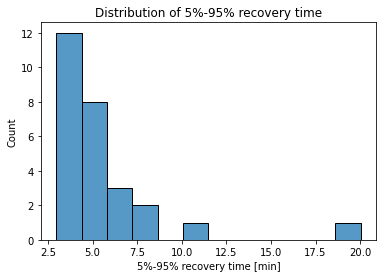

In [5]:


def model_fun(x,a,b,c,d,e):    
    """Error function + exponention"""
    return  a + b * erf((x-c) / d) * np.exp(-e*x)

def initialize_parameters(x,y,alpha=0.2):
    """Initialize all model parameters prior to curve_fit"""
    t0 = 0
    t1 = 0
    t2 = 0    
    y = medfilt(y, 5)
    a,b  = y.min(), y.max()    
    corr = 2*erfinv(1-alpha)           
    for i, yi in enumerate(y):        
        if yi > a + alpha*(b-a) and t0 == 0:            
            t0 = np.interp(a + alpha*(b-a), y[i-2:i+2], x[i-2:i+2])
        if yi > a + (1-alpha)*(b-a) and t1 == 0:            
            t1 = np.interp(a + (1-alpha)*(b-a), y[i-2:i+2], x[i-2:i+2])
        if yi > a + 0.5*(b-a) and t2==0:
            t2 = np.interp(a + 0.5*(b-a), y[i-2:i+2], x[i-2:i+2])    
    return np.array([0.5*(a+b),0.5*(b-a),t2,(t1-t0)/corr,1e-6])


def fit_model(name, group, metric):
    """Least square fit of the model parameters"""    
    x, y = group['Time [min]'], group[metric]
    x = x[np.isfinite(y)]
    y = y[np.isfinite(y)] 
    sigma = np.ones(x.shape)
    p0 = initialize_parameters(x,y)    
    p, cov = curve_fit(model_fun, x, y, p0)    
    return {
        'Parasite': name,
        'Offset [au]': p[0],
        'Amplitude [au]': p[1],
        'Time mid point [min]': p[2],
        'Time constant [min]': p[3],
        'Exponential decay [min^-1]': p[4],        
        '5%-95% recovery time [min]': 2.38 * p[3],
    }

parameters = pd.DataFrame.from_records([fit_model(n,g,'Mean intensity') for n, g in profiles.groupby('Parasite')])
sns.histplot(parameters, x='5%-95% recovery time [min]')
plt.title('Distribution of 5%-95% recovery time');
plt.savefig(figure_folder/'histogram of recovery times.pdf')

Customized statistics

In [6]:
parameters.agg(["count","mean", "std", "min",q25, q50, q75, "max",  f1, f2])

,Parasite,Offset [au],Amplitude [au],Time mid point [min],Time constant [min],Exponential decay [min^-1],5%-95% recovery time [min]
count,27.000000,27.000000,27.000000,27.000000,27.000000,27.000000,27.000000
mean,14.000000,186.610649,73.586637,56.608845,2.361143,-0.005191,5.619521
std,7.937254,50.323321,117.673249,20.029631,1.429776,0.021874,3.402868
min,1.000000,119.680116,0.897229,28.739605,1.245047,-0.068152,2.963211
25%,7.500000,150.903310,19.723433,42.092615,1.600675,-0.015008,3.809606
50%,14.000000,165.151282,39.540345,51.866169,2.071187,-0.004420,4.929425
75%,20.500000,222.318226,65.341709,68.106419,2.541876,0.004615,6.049665
max,27.000000,304.760175,517.182052,102.048308,8.413070,0.043893,20.023106
madstd,10.378200,31.520759,32.651568,21.641032,0.698875,0.014832,1.663322
25%-75%,13.000000,71.414915,45.618276,26.013805,0.941201,0.019624,2.240059


## Heatmaps

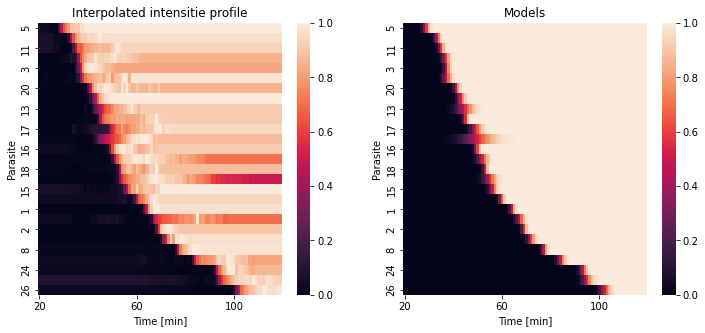

In [7]:
def resample_intensities(p:pd.DataFrame, x:np.ndarray):
    y = np.interp(x, p['Time [min]'], p['Mean intensity'])
    y0, y1 = p['Mean intensity'].min(), p['Mean intensity'].max()
    t0, t1 = p['Time [min]'].min(), p['Time [min]'].max()
    z = (y - y0) / (y1 - y0)
    #y[x < t0] = np.NaN
    #y[x > t1] = np.NaN
    #z[x < t0] = np.NaN
    #z[x > t1] = np.NaN  
    return pd.DataFrame({'Parasite':[p['Parasite'].iloc[0] for k in x], 
                         'Time [min]':x, 
                         'Intensity [au]': y, 
                         'Normalized intensity [au]':z})
    
def generate_models(p:pd.DataFrame, x:np.ndarray):
    """Generate models profiles from parameters and time values"""
    yhat = model_fun(x, p[1],p[2],p[3],p[4],p[5])
    return pd.DataFrame({
        'Parasite': [p['Parasite'] for x in range(len(x))],
        'Time [min]' : x,
        'Model [au]': yhat,
        'Normalized model [au]': model_fun(x, 0.5, 0.5, p[3], p[4], 0),        
    })

t = np.arange(20, 120, 1)
interpolated = profiles.groupby('Parasite').apply(partial(resample_intensities,x=t)).droplevel('Parasite')
models = pd.concat([generate_models(p,t) for p in parameters.iloc])

fig, ax = plt.subplots(1,2,figsize=(12,5))
order = np.argsort(parameters['Time mid point [min]']).to_numpy() + 1

sns.heatmap(
    interpolated.pivot_table('Normalized intensity [au]', 'Time [min]', 'Parasite').transpose().reindex(order),
    xticklabels = 40,
    linewidths = 0.0,     
    rasterized = True,
    vmin=0,
    vmax=1,
    ax=ax[0])
plt.xlim([20,125])
ax[0].set_title('Interpolated intensitie profile')

sns.heatmap(
    models.pivot_table('Normalized model [au]', 'Time [min]', 'Parasite').transpose().reindex(order),
    xticklabels = 40,
    linewidths = 0.0, 
    rasterized = True,
    #vmin=0,
    #vmax=1,
    ax=ax[1])
ax[1].set_title('Models')

plt.savefig(figure_folder/'heatmap.pdf')


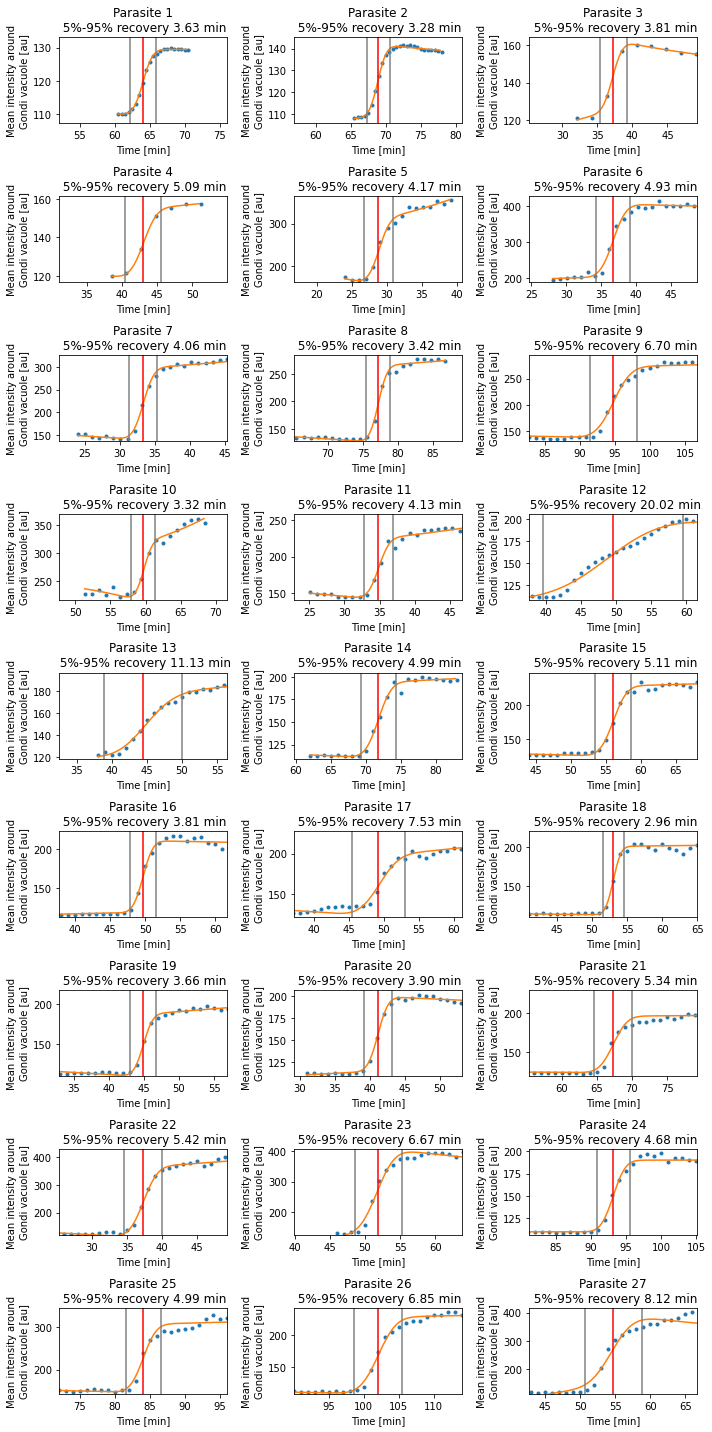

In [8]:
def plot_profile(profile, parameter, ax):    
    ax.plot(profile['Time [min]'], profile['Mean intensity'], '.')
    x = np.arange(profile['Time [min]'].min(), profile['Time [min]'].max(), 0.25)    
    y0, y1 = 0.975*profile['Mean intensity'].min(), 1.025*profile['Mean intensity'].max()
    p = parameter.iloc[0]
    yhat = model_fun(x, *p[1:6])
    ax.plot(x,yhat)
    t2 = p[3]
    dt = p[6]/2    
    ax.plot([t2,t2],[y0,y1],color='red')
    ax.plot([t2+dt,t2+dt],[y0,y1],color='gray')
    ax.plot([t2-dt,t2-dt],[y0,y1],color='gray')
    pid = parameter["Parasite"].item()
    ax.set_title(f'Parasite {pid}\n 5%-95% recovery {2*dt:.2f} min')
    ax.set_xlim([t2-12, t2+12])
    ax.set_ylim(y0,y1)
    ax.set_xlabel('Time [min]')
    ax.set_ylabel('Mean intensity around\nGondi vacuole [au]')
    
fig,ax = plt.subplots(9,3,figsize=(10,20))
for p in parameters['Parasite']:
    plot_profile(profiles[profiles['Parasite']==p], parameters[parameters['Parasite']==p],ax=ax.ravel()[p-1])
fig.tight_layout()
plt.savefig(figure_folder/f'profile-all-parasites.pdf',  bbox_inches='tight')


Save all profiles as individual graph

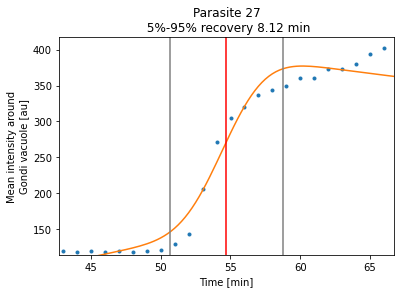

In [9]:
for p in [1,2]:
    plt.clf()
    plot_profile(profiles[profiles['Parasite']==p], parameters[parameters['Parasite']==p],ax=plt.gca())        
    plt.savefig(figure_folder/f'profile-parasite{p}.pdf',  bbox_inches='tight')

Export all data into an MS Excel spreadsheet.

In [10]:
with pd.ExcelWriter(figure_folder/'parasite-intensity.xlsx') as xls:
    summary.to_excel(xls,sheet_name='Info',index=False)
    parameters.to_excel(xls,sheet_name='Model parameters',index=False)
    parameters.agg(["count","mean", "std", "min",q25, q50, q75, "max",  f1, f2]).to_excel(xls,sheet_name='Statistics')
    for n,g in profiles.groupby('Parasite'):
        g.reset_index().drop(columns=['index','Parasite']).to_excel(xls,sheet_name=f'Parasite {n}',index=False)

# Exponential model

In [11]:
figure_folder = folder / 'figure_020224_exp'
figure_folder.mkdir(parents=True, exist_ok=True)

In [12]:

def model_exp(x,a,b,c,d,e):
    """Exponential x Error function model"""
    #return a + b * (0.5+0.5*erf((x - c) / e)) * ( 1 - np.exp(-(x - c) / d))
    return a + b * np.maximum(0, 1 - np.exp(-(x - c) / d)) * np.exp(-e*x)

def initialize_parameters(x,y):
    ym = medfilt(y,3)
    a, b = ym.min(), ym.max()
    alpha = 0.2
    y0, y1 = a + alpha * (b - a), a + (1-alpha) * (b - a)
    x0, x1 = 0.0, 0.0 
    for i, yi in enumerate(ym):  
        if yi > y0 and x0 == 0:
            x0 = x[i-1] + (y0-y[i-1]) * (x[i] - x[i-1]) / (y[i] - y[i-1])
        if yi > y1 and x1 == 0:
            x1 = x[i-1] + (y1-y[i-1]) * (x[i] - x[i-1]) / (y[i] - y[i-1])
    p = [a, b - a, x0, (x1 - x0) / 2,0]
    l = [0.9 * a - 0.1 * b, 0.75*(b-a), x0 - 1, 0.1*(x1-x0),0]
    u = [0.9 * a + 0.1 * b, 1.25*(b-a), x0 + 1, 10*(x1-x0),1]    
    return {'p0':p, 'bounds':(l,u)}

def fit_model_exp(name, group, metric):
    """Least square fit of the model parameters"""
    x, y = group['Time [min]'], group[metric]
    x = np.array(x[np.isfinite(y)])
    y = np.array(y[np.isfinite(y)])
    init = initialize_parameters(x,y)    
    p, cov = curve_fit(model_exp, x, y, **init)    
    return {    
        'Parasite': name,
        'offset': p[0],
        'amplitude': p[1],        
        'start [min]': p[2],
        'time [min]': p[3],        
        'bleaching [min^-1]': p[4]
    }

p1 = pd.DataFrame.from_records([fit_model_exp(n,g,'Fraction') for n, g in profiles.groupby('Parasite')])
p1.columns = pd.MultiIndex.from_tuples([('Fraction',c) for c in p1.columns])
p2 = pd.DataFrame.from_records([fit_model_exp(n,g,'Mean intensity') for n, g in profiles.groupby('Parasite')])
p2.columns = pd.MultiIndex.from_tuples([('Mean intensity',c) for c in p2.columns])
#parameters = pd.merge(p1,p2,on='Parasite')


In [13]:
parameters = pd.merge(p1.drop(columns=('Fraction','Parasite')),p2.drop(columns=('Mean intensity','Parasite')),left_index=True,right_index=True)
parameters['Parasite'] = p1['Fraction','Parasite']
parameters

Fraction                                                      \
          offset amplitude start [min] time [min] bleaching [min^-1]   
0   5.208422e-02  0.879525   62.776318   1.630125       3.455505e-03   
1   1.812078e-02  0.817200   67.667824   1.566998       4.304438e-13   
2   5.933051e-02  0.835768   35.839646   1.408306       1.962160e-19   
3   2.655126e-02  0.810832   41.769607   1.553597       1.243374e-24   
4   7.209579e-03  1.114462   27.686412   1.832399       3.503959e-03   
5   4.523312e-02  1.023947   35.394942   1.344497       3.668150e-03   
6   4.146705e-02  0.944884   31.952826   1.507759       1.357658e-18   
7   2.069926e-11  0.967854   75.922527   1.526551       3.066371e-14   
8   9.920246e-03  1.004715   92.553996   3.009487       8.827833e-04   
9   1.016037e-01  0.452665   59.938458   3.708088       2.777910e-03   
10  3.478233e-03  0.490378   33.749987   2.776237       2.649157e-29   
11  1.021050e-02  1.114011   42.591582   6.699769       2.190214e-03   
12  7.983832e-02  0.988777   42.168137   3.304087       5.048237e-03   
13  1.053948e-02  0.985696   70.088193   1.870320       1.193699e-15   
14  1.110244e-01  0.827149   54.154082   1.723218       6.150605e-22   
15  2.471725e-03  1.220366   48.527109   1.065727       4.385114e-03   
16  5.959045e-04  0.919782   48.675871   0.885717       6.210344e-04   
17  3.691793e-03  0.914844   52.186146   0.926509       7.593244e-17   
18  7.518797e-03  0.943936   44.031563   1.176746       1.625104e-22   
19  8.850513e-03  1.066850   40.473707   0.823727       5.600845e-03   
20  3.961617e-02  0.879118   65.673058   1.623005       4.229288e-04   
21  1.263737e-02  1.060281   36.539108   0.792073       2.629625e-03   
22  3.270333e-02  1.172460   50.196927   1.069640       4.519695e-03   
23  2.946984e-03  0.942768   91.706016   0.933062       1.977851e-04   
24  7.114814e-02  0.841672   82.320679   1.780948       1.987948e-32   
25  2.514536e-04  1.144347   99.960120   2.627135       2.257239e-03   
26  1.603036e-02  1.250000   51.741531   2.293253       4.120052e-03   

   Mean intensity                                                        \
           offset   amplitude start [min] time [min] bleaching [min^-1]   
0      110.889666   24.616700   63.187685   1.225300       3.797766e-03   
1      109.728041   41.514314   68.133105   0.928702       4.071286e-03   
2      121.369941   48.334360   36.088948   0.767089       6.653289e-03   
3      120.547651   36.903074   41.992458   1.609021       1.430958e-22   
4      170.144563  180.295556   27.590880   2.446267       2.069495e-16   
5      204.054508  260.236807   35.156238   2.103156       5.367561e-03   
6      147.686159  164.279164   32.123814   1.831676       2.751680e-20   
7      133.361288  141.346873   76.232125   1.433740       1.186308e-15   
8      142.136700  185.785434   92.655724   3.112944       2.629488e-03   
9      230.026831  129.445425   58.758117   2.568343       5.418547e-22   
10     147.032149   96.200094   33.286546   3.014731       1.522826e-24   
11     112.798657  111.400102   42.922496   8.180026       3.406096e-03   
12     122.947770   82.919108   41.761103   5.822318       3.641569e-03   
13     113.495550  108.250921   70.340308   2.059223       2.991858e-03   
14     128.445110  103.558551   54.619173   1.981357       1.570820e-14   
15     118.021702  124.570285   48.598727   1.329860       5.108739e-03   
16     130.150865   85.321227   47.390640   4.365416       3.105456e-19   
17     115.569782   86.252493   52.489138   0.785450       3.545909e-19   
18     114.580215   85.421171   43.659281   2.234949       7.635391e-29   
19     114.252952  108.501616   40.304953   1.201659       5.414748e-03   
20     125.465883  104.199545   65.362545   3.371938       3.997231e-03   
21     124.882341  269.006823   35.728036   2.527457       8.558349e-18   
22     144.019463  329.910892   50.193740   1.756044       5.606364e-03   
23     110.555363  110.125244   92.103455   

Inspect the distribution of completion time

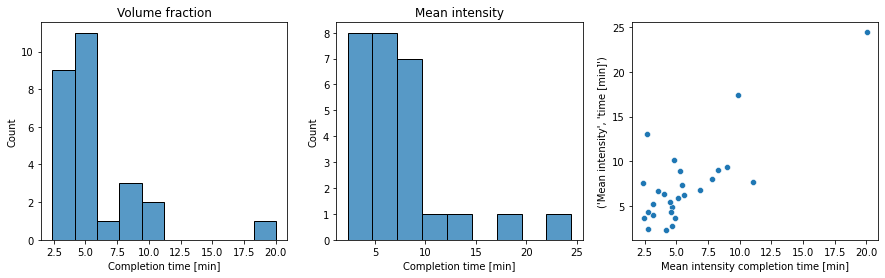

In [14]:
plt.figure(figsize=(15,4))
plt.subplot(131)
sns.histplot(x=2.99*parameters['Fraction','time [min]'])
plt.title('Volume fraction')
plt.xlabel('Completion time [min]')
plt.subplot(132)
sns.histplot(x=2.99*parameters['Mean intensity','time [min]'])
plt.title('Mean intensity')
plt.xlabel('Completion time [min]')
plt.subplot(133)
sns.scatterplot(x=2.99*parameters['Fraction','time [min]'], y=2.99*parameters['Mean intensity','time [min]'])
plt.xlabel('Volume fraction completion time [min]')
plt.xlabel('Mean intensity completion time [min]')
plt.savefig(figure_folder / 'Distribution of completion time.pdf')


In [15]:
parameters.agg(["count","mean", "std", "min",q25, q50, q75, "max",  f1, f2])

Fraction                                                       \
               offset  amplitude start [min] time [min] bleaching [min^-1]   
count    2.700000e+01  27.000000   27.000000  27.000000       2.700000e+01   
mean     2.870644e-02   0.948677   55.047643   1.905888       1.714114e-03   
std      3.190444e-02   0.184949   19.923227   1.231642       1.938826e-03   
min      2.069926e-11   0.452665   27.686412   0.792073       1.987948e-32   
25%      5.450686e-03   0.860395   41.121657   1.123193       3.864505e-17   
50%      1.263737e-02   0.944884   50.196927   1.566998       6.210344e-04   
75%      4.335009e-02   1.063565   66.670441   2.081786       3.479732e-03   
max      1.110244e-01   1.250000   99.960120   6.699769       5.600845e-03   
madstd   1.785268e-02   0.161776   20.249083   0.737383       9.207456e-04   
25%-75%  3.789940e-02   0.203171   25.548784   0.958593       3.479732e-03   

        Mean intensity                                                        \
                offset   amplitude start [min] time [min] bleaching [min^-1]   
count        27.000000   27.000000   27.000000  27.000000       2.700000e+01   
mean        133.492700  138.227115   55.012644   2.444907       2.446556e-03   
std          28.628059   85.815103   20.065884   1.596180       2.437477e-03   
min         109.728041   24.616700   27.590880   0.767089       7.635391e-29   
25%         114.416583   85.836832   41.033028   1.441541       4.456470e-18   
50%         124.882341  110.125244   50.193740   2.103156       2.991858e-03   
75%         143.078082  172.287360   66.747825   2.826209       4.034258e-03   
max         230.026831  359.319642  100.153101   8.180026       6.884319e-03   
madstd       16.882056   40.335817   20.911765   0.992475       4.435729e-03   
25%-75%      28.661498   86.450528   25.714797   1.384668       4.034258e-03   

          Parasite  
                    
count    27.000000  
mean     14.000000  
std       7.937254  
min       1.000000  
25%       7.500000  
50%      14.000000  
75%      20.500000  
max      27.000000  
madstd   10.378200  
25%-75%  13.000000

Display all profiles

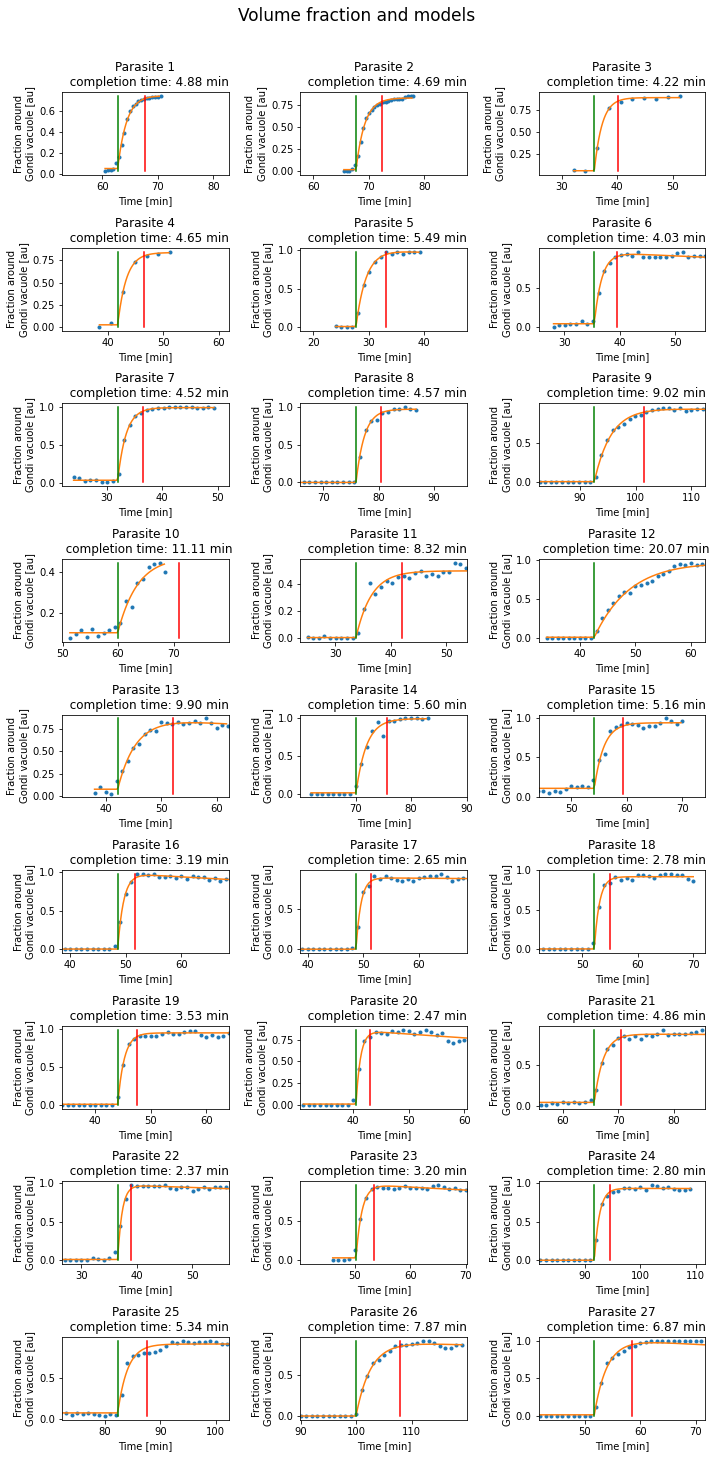

In [16]:
def plot_fraction_profile(profile, parameter, metric, ax, setrange=False):    
    ax.plot(profile['Time [min]'], profile[metric], '.')
    x = np.arange(profile['Time [min]'].min(), profile['Time [min]'].max(), 0.25)    
    y0, y1 = profile[metric].min(), profile[metric].max()
    p = parameter.iloc[0]
    yhat = model_exp(x, p[metric,'offset'], p[metric,'amplitude'], p[metric,'start [min]'], p[metric,'time [min]'],p[metric, 'bleaching [min^-1]'])
    ax.plot(x,yhat)    
    t0 = p[metric, 'start [min]']    
    dt =  -np.log(0.05) * p[metric,'time [min]']
    t2 = t0 + dt
    ax.plot([t0,t0],[y0,y1], color='green')    
    ax.plot([t2,t2],[y0,y1], color='red')
    pid = parameter["Parasite"].item()
    ax.set_title(f'Parasite {pid}\n  completion time: {dt:.2f} min')
    if setrange:
        ax.set_xlim(t0-10, t0+20)
        #ax.set_ylim(0.95 * y0 - 0.05 * y1 , 1.05 * y1 - 0.05 * y0)
        ax.set_xlabel('Time [min]')
    ax.set_ylabel(f'{metric} around\nGondi vacuole [au]')
    
fig,ax = plt.subplots(9,3,figsize=(10,20))
for p in parameters['Parasite']:
    plot_fraction_profile(profiles[profiles['Parasite']==p], parameters[parameters['Parasite']==p],'Fraction', ax=ax.ravel()[p-1], setrange=True)
plt.suptitle('Volume fraction and models', y = 1.01, fontsize=17)
fig.tight_layout()
plt.savefig(figure_folder/'Volume fraction for all parasites.pdf')

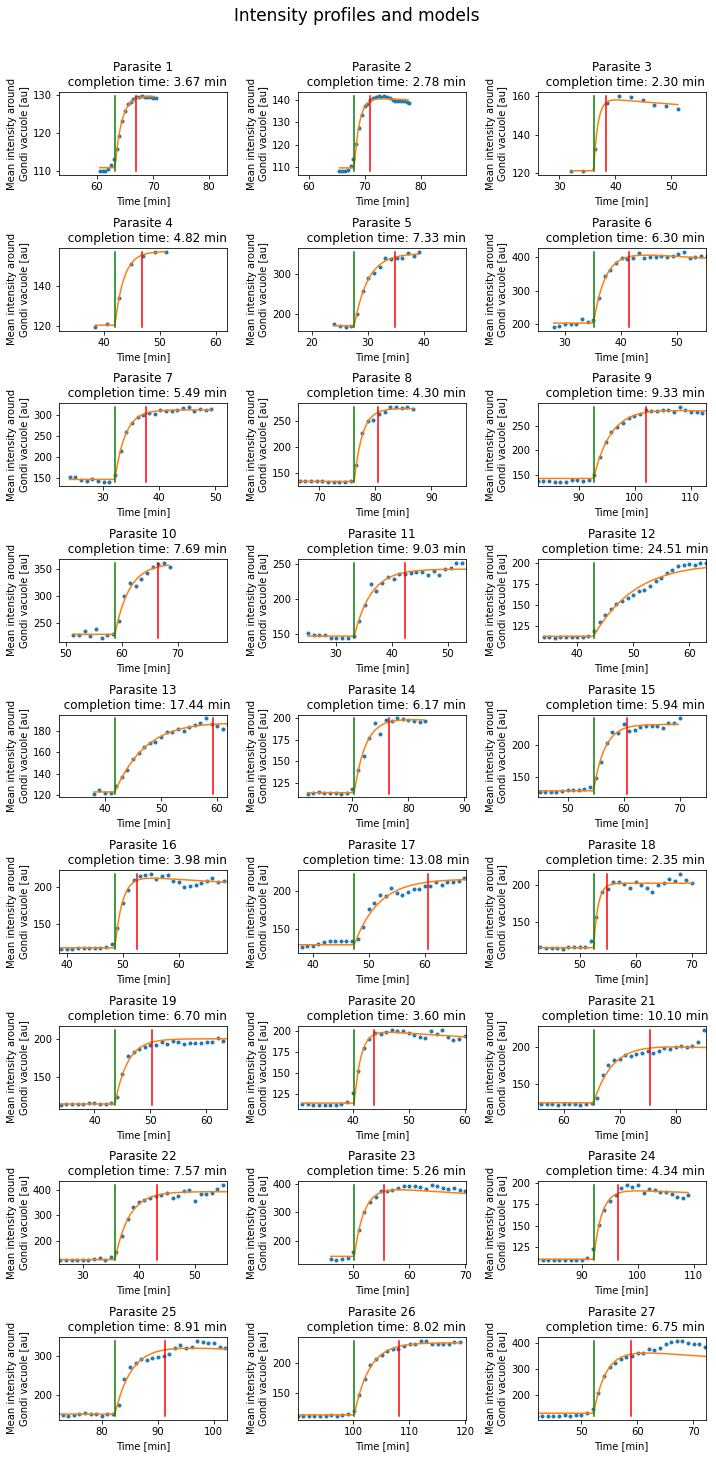

In [17]:
fig,ax = plt.subplots(9,3,figsize=(10,20))
for p in parameters['Parasite']:
    plot_fraction_profile(profiles[profiles['Parasite']==p], parameters[parameters['Parasite']==p],'Mean intensity', ax=ax.ravel()[p-1],setrange=True)
plt.suptitle('Intensity profiles and models', y = 1.01, fontsize=17)
fig.tight_layout()
plt.savefig(figure_folder/'Intensity profile for all parasites.pdf')


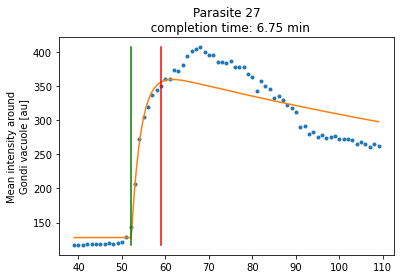

In [18]:
for p in [1,2]:
    plt.clf()
    plot_fraction_profile(profiles[profiles['Parasite']==p], parameters[parameters['Parasite']==p],'Mean intensity',ax=plt.gca())        
    plt.savefig(figure_folder/f'Intensity profile parasite{p}.pdf',  bbox_inches='tight')

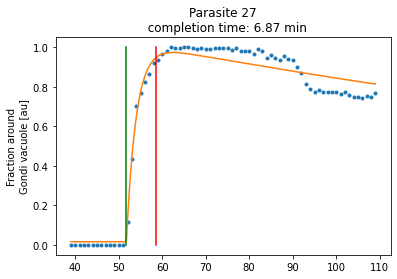

In [19]:
for p in [1,2]:
    plt.clf()
    plot_fraction_profile(profiles[profiles['Parasite']==p], parameters[parameters['Parasite']==p],'Fraction',ax=plt.gca())        
    plt.savefig(figure_folder/f'Volume fraction for parasite{p}.pdf',  bbox_inches='tight')

### Heatmaps

Heatmap for intensities

Text(0.5, 0.98, 'Exponential recovery model for intensity profiles')

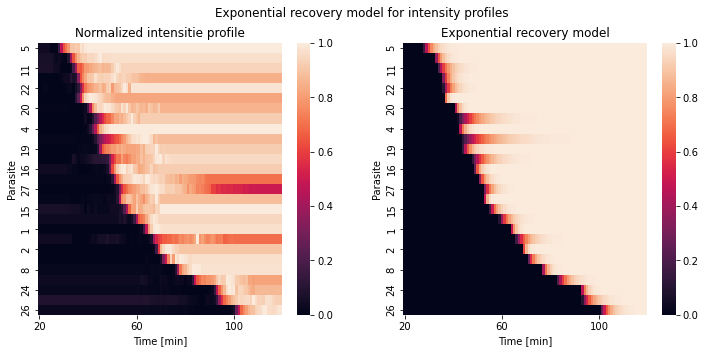

In [20]:
def resample_intensities(p:pd.DataFrame, x:np.ndarray, metric:str):
    y = np.interp(x, p['Time [min]'], p[metric])
    y0, y1 = p[metric].min(), p[metric].max()
    t0, t1 = p['Time [min]'].min(), p['Time [min]'].max()
    z = (y - y0) / (y1 - y0)
    #y[x < t0] = np.NaN
    #y[x > t1] = np.NaN
    #z[x < t0] = np.NaN
    #z[x > t1] = np.NaN  
    return pd.DataFrame({'Parasite':[p['Parasite'].iloc[0] for k in x], 
                         'Time [min]':x, 
                         metric: y, 
                         f'Normalized {metric}':z})
    
def generate_models(p:pd.DataFrame, x:np.ndarray, metric:str):
    """Generate models profiles from parameters and time values"""    
    yhat = model_exp(x, p[metric, 'offset'], p[metric,'amplitude'], p[metric,'start [min]'], p[metric, 'time [min]'],p[metric, 'bleaching [min^-1]'])           
    return pd.DataFrame({
        'Parasite': [p['Parasite'].item() for x in range(len(x))],
        'Time [min]' : x,
        'Model [au]': yhat,
        'Normalized model [au]': model_exp(x, 0, 1, p[metric,'start [min]'], p[metric,'time [min]'],0)   ,        
    })

t = np.arange(20, 120, 1)
interpolated = profiles.groupby('Parasite').apply(partial(resample_intensities,x=t, metric='Mean intensity')).droplevel('Parasite')
models = pd.concat([generate_models(p,t,'Mean intensity') for p in parameters.iloc])

fig, ax = plt.subplots(1,2,figsize=(12,5))
order = np.argsort(parameters['Mean intensity','start [min]']).to_numpy() + 1

sns.heatmap(
    interpolated.pivot_table('Normalized Mean intensity', 'Time [min]', 'Parasite').transpose().reindex(order),
    xticklabels = 40,
    linewidths = 0.0,     
    rasterized = True,
    vmin=0,
    vmax=1,
    ax=ax[0])
plt.xlim([20,125])
ax[0].set_title('Normalized intensitie profile')

sns.heatmap(
    models.pivot_table('Normalized model [au]', 'Time [min]', 'Parasite').transpose().reindex(order),
    xticklabels = 40,
    linewidths = 0.0, 
    rasterized = True,
    vmin=0,
    vmax=1,
    ax=ax[1])
ax[1].set_title('Exponential recovery model')
plt.suptitle('Exponential recovery model for intensity profiles')

#plt.savefig(figure_folder/'Intensity heatmap.pdf')


Heatmap for volume fraction

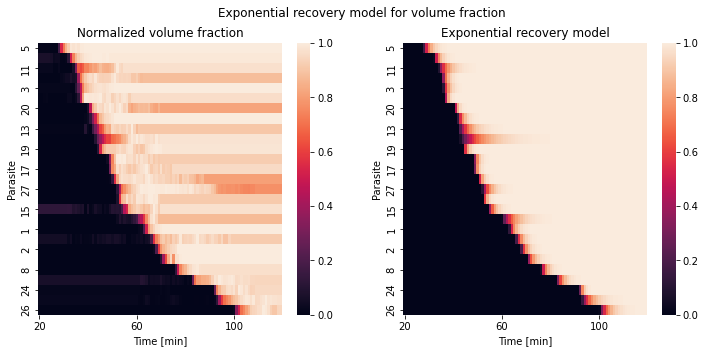

In [21]:
t = np.arange(20, 120, 1)
interpolated = profiles.groupby('Parasite').apply(partial(resample_intensities,x=t,metric='Fraction')).droplevel('Parasite')
models = pd.concat([generate_models(p,t,'Fraction') for p in parameters.iloc])

fig, ax = plt.subplots(1,2,figsize=(12,5))
order = np.argsort(parameters['Fraction','start [min]']).to_numpy() + 1

sns.heatmap(
    interpolated.pivot_table('Normalized Fraction', 'Time [min]', 'Parasite').transpose().reindex(order),
    xticklabels = 40,
    linewidths = 0.0,     
    rasterized = True,
    vmin=0,
    vmax=1,
    ax=ax[0])
plt.xlim([20,125])
ax[0].set_title('Normalized volume fraction')

sns.heatmap(
    models.pivot_table('Normalized model [au]', 'Time [min]', 'Parasite').transpose().reindex(order),
    xticklabels = 40,
    linewidths = 0.0, 
    rasterized = True,
    vmin=0,
    vmax=1,
    ax=ax[1])
ax[1].set_title('Exponential recovery model')
plt.suptitle('Exponential recovery model for volume fraction')

plt.savefig(figure_folder/'Volume fraction heatmap.pdf')

# Export all to excel

In [22]:
with pd.ExcelWriter(figure_folder/'Parasite coat recovery data.xlsx') as xls:
    summary.to_excel(xls,sheet_name='Info',index=False)
    parameters.to_excel(xls,sheet_name='Model parameters')
    parameters.agg(["count","mean", "std", "min",q25, q50, q75, "max",  f1, f2]).to_excel(xls,sheet_name='Statistics')
    for n,g in profiles.groupby('Parasite'):
        g.reset_index().drop(columns=['index','Parasite']).to_excel(xls,sheet_name=f'Parasite {n}',index=False)